5) Using sklearn, considering a 10-fold stratified cross validation (random=0), plot the cumulative testing confusion matrices of kNN (uniform weights, k = 5, Euclidean distance) and Naive Bayes (Gaussian assumption). Use all remaining classifier parameters as default.

Loads and reads the parkinson's disease data

In [70]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff
import seaborn as sns
import matplotlib.pyplot as plt

data = loadarff('pd_speech.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')

X = df.drop('class', axis=1)
Y = df['class']

Creates the 10-fold cross validator, the KNN and the Gaussian Naive Bayes. Caluculates the confusion matrix of kNN and Naive Bayes:

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0) 

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')
nb = GaussianNB()

def calculate_conf_matrix(x, X, Y):
    conf_mat = np.zeros((2, 2)) #inicializates the confusion matrix at 0's
    for train, test in skf.split(X, Y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        Y_train, Y_test = Y.iloc[train], Y.iloc[test]

        x.fit(X_train, Y_train)

        Y_pred = x.predict(X_test)

        conf_mat += np.array(confusion_matrix(Y_test, Y_pred, labels=['0', '1']))
    return conf_mat

nb_confusion = pd.DataFrame(calculate_conf_matrix(nb, X, Y), index=['0', '1'], columns=['Predicted 0', 'Predicted 1'])
knn_confusion = pd.DataFrame(calculate_conf_matrix(knn, X, Y), index=['0', '1'], columns=['Predicted 0', 'Predicted 1'])



Plot the confusion matrices of kNN and Bayes Naive

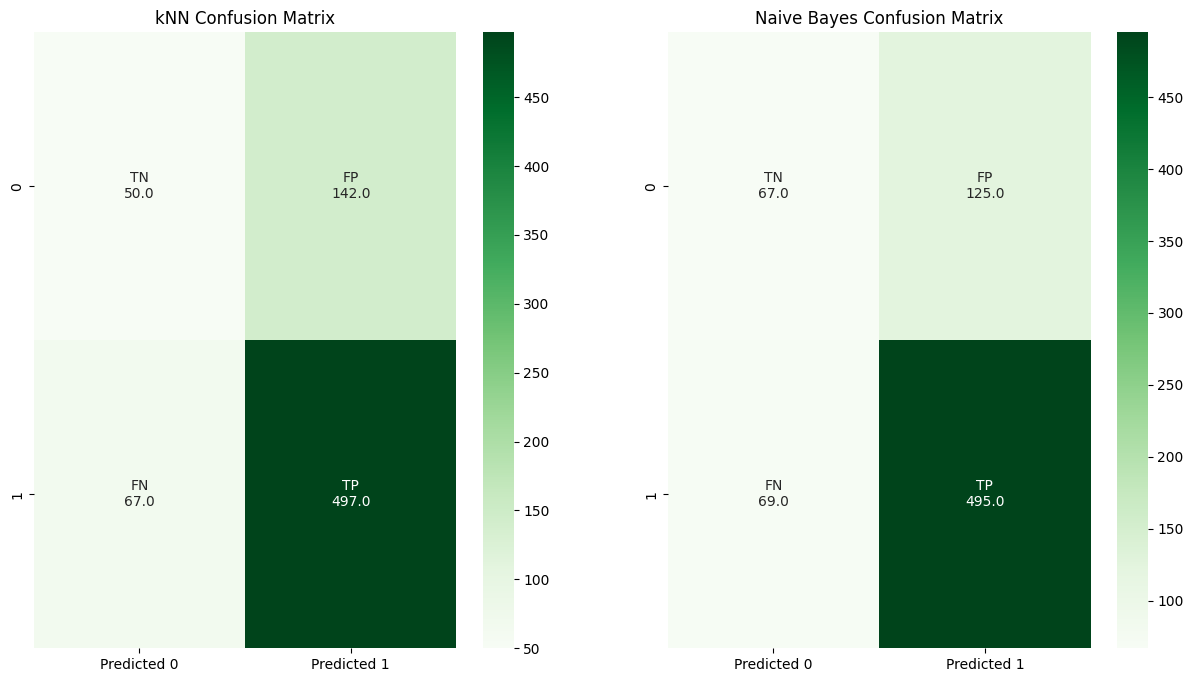

In [72]:
titles = ["kNN Confusion Matrix", "Naive Bayes Confusion Matrix"]
matrices = [knn_confusion, nb_confusion]
plt.figure(figsize= (15, 8))
for i in range(len(matrices)):
    plt.subplot(1, 2, i+1)
    plt.title(titles[i])
    labels = np.array([["TN\n" + str(matrices[i].iat[0, 0]), "FP\n" + str(matrices[i].iat[0, 1])], ["FN\n" + str(matrices[i].iat[1, 0]), "TP\n" + str(matrices[i].iat[1, 1])]])
    sns.heatmap(matrices[i], annot=labels, fmt='', cmap="Greens")


In [73]:
#TODO


---

##### 7) Enumerate three possible reasons that could underlie the observed differences in predictive accuracy between 𝑘NN and Naïve Bayes.

Reasons:  
1. #TODO
2. #TODO  
3. #TODO  

---

TODO Cenas

- [ ]: Diferença entre [KNeighborsRegressor e KNeighborsClassifier](https://stackoverflow.com/questions/52794075/sklearn-kneighborsregressor-vs-kneighborsclassifer)